<a href="https://colab.research.google.com/github/ProshkinNV/OpenCV/blob/main/GitHub_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузка библиотек

In [ ]:
!pip install opendatasets

Импорт библиотек

In [ ]:
import opendatasets as op
import random

import tensorflow as tf                                                               # библиотека Tensorflow
import keras                                                                          # библиотека Keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Rescaling     # cлои библиотеки Keras
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate             # cлои библиотеки Keras
from keras.layers import Rescaling, Resizing                                          # cлои библиотеки Keras
from keras.models import Model, Sequential                                            # конструкторы построения моделей библиотеки Keras

from keras.optimizers import Adam                                                     # оптимизатор Adam
from keras.preprocessing.image import  load_img                                       # загрузка изображений
from keras.utils import to_categorical                                                # преобразует вектор класса (целые числа) в двоичную матрицу класса

import random                                                                         # генератор случайных чисел

import numpy as np                                                                    # библиотека линейной алгебры
import pandas as pd                                                                   # библиотека обработки табличных данных
import os                                                                             # библиотека работы с функциями операционной системы, в том числе с файлами
import albumentations as A                                                            # библиотека аугментации изображений (https://albumentations.ai/)

import matplotlib.pyplot as plt                                                       # библиотека для рисования графиков
%matplotlib inline


from PIL import Image


import pandas as pd
import numpy as np
import zipfile
import os
import glob
import random
import sys

import skimage.io                           #Used for imshow function
import skimage.transform                    #Used for resize function
from skimage.morphology import label        #Used for Run-Length-Encoding RLE to create final submission
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

Загрузка Датасэта

In [ ]:
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: Nikolay Histeria
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database


100%|██████████| 778M/778M [00:07<00:00, 108MB/s]


Файловая система Датасэта


In [ ]:
PATH_DATASET = '/content/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal'
DIR_IMAGE = 'images'
DIR_MASK = 'masks'

Параметры изображений

In [ ]:
SIZE_IMAGE = (256,256)
NUM_CLASSES = 2
BATCH_SIZE = 8

IMG_WIDTH       = 256
IMG_HEIGHT      = 256
IMG_CHANNELS    = 3

Просмотр содержимого ДС

In [ ]:
temp = os.listdir(os.path.join(PATH_DATASET,DIR_IMAGE))

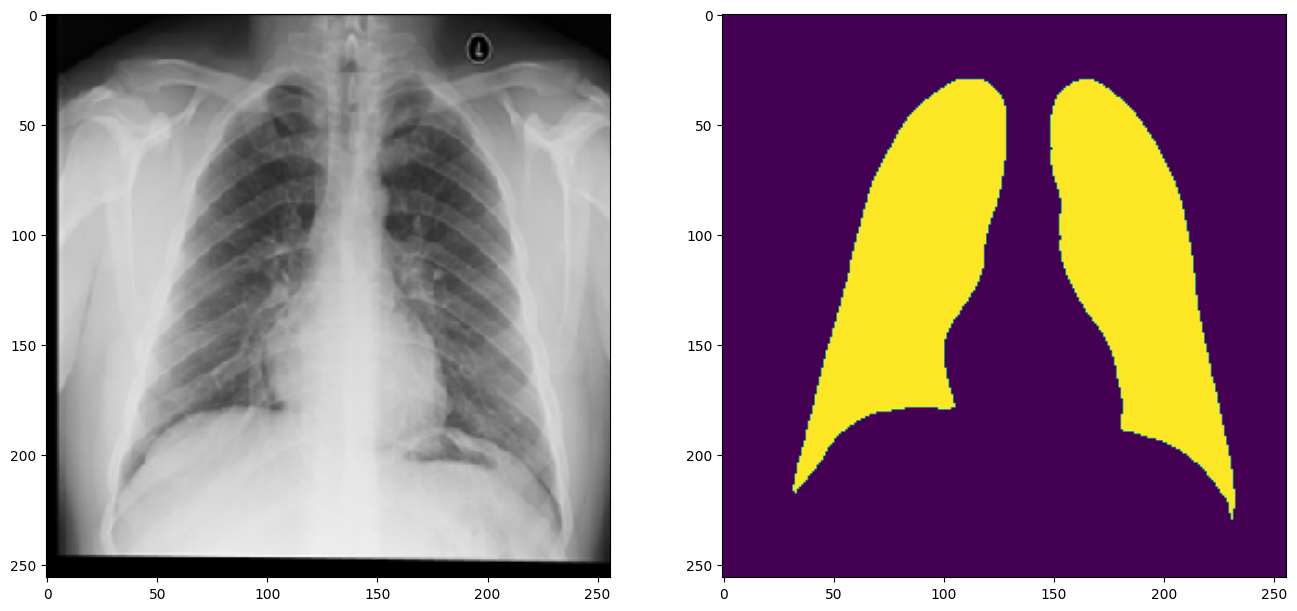

In [ ]:
Origin_image = os.path.join(PATH_DATASET,DIR_IMAGE,temp[0])
Mask_image = os.path.join(PATH_DATASET,DIR_MASK, temp[0])

fig, axs = plt.subplots(1, 2, figsize=(16, 8))                          # задаем область для построения (канвас)

img = np.array(load_img(Origin_image, target_size=(256, 256), color_mode='rgb'))
mask = np.array(load_img(Mask_image, target_size=(256, 256), color_mode = "grayscale"))

axs[0].imshow(img)  # отрисовываем оригинальное изображение
axs[0].grid(False)

axs[1].imshow(mask) # отрисовываем маску (одноканальное изображение, каждый класс отображается как отдельный цвет)
axs[1].grid(False)

Создание выборок для обучения

In [ ]:
input_img_path = sorted(
    [
        os.path.join(PATH_DATASET, DIR_IMAGE, fname)
        for fname in os.listdir(os.path.join(PATH_DATASET, DIR_IMAGE))
        if fname.endswith(".png")
    ]
)

target_img_path = sorted(
    [
        os.path.join(PATH_DATASET, DIR_MASK, fname)
        for fname in os.listdir(os.path.join(PATH_DATASET, DIR_MASK))
        if fname.endswith(".png")
    ]
)

In [ ]:
class datasetGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_path, target_img_path = None, num_classes = NUM_CLASSES, validation = False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
        self.validation = validation


    def __len__(self):
        """Возвращает число мини-батчей обучающей выборки"""
        return len(self.target_img_path) // self.batch_size


    def __getitem__(self, idx):
        """Возвращает кортеж (input, target) соответствующий индексу пакета idx"""

        # Формируем пакеты из ссылок путем среза длинной в batch_size и возвращаем пакет по индексу
        batch_input_img_path = self.input_img_path[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_target_img_path = self.target_img_path[idx*self.batch_size:(idx+1)*self.batch_size]

        # Создадим массив numpy, заполненный нулями, для входных данных формы (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 2) и типа данных float32
        x = np.zeros((self.batch_size, *self.img_size,3), dtype="float32")

        # Создадим массив numpy, заполненный нулями, для выходных данных формы (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 1) и типа данных uint8
        y = np.zeros((self.batch_size, *self.img_size, NUM_CLASSES), dtype="uint8")

        # В цикле заполняем массивы с изображениями x и y
        # Перебираем пакеты из путей batch_input_img_path и batch_target_img_path к изображениям
        # zip возвращает для нескольких последовательностей список кортежей из элементов последовательностей с одинаковыми индексами
        for _, paths in enumerate(zip(batch_input_img_path, batch_target_img_path)):

            # Загружаем изображение и маску используя путь файловой системы
            img = np.array(load_img(paths[0], target_size=self.img_size, color_mode='rgb'))         # 3 канала для изображения
            mask = np.array(load_img(paths[1], target_size=self.img_size, color_mode='grayscale' ))  # 1 канал для маски

            if self.validation == False:
                # Применяем аугментацию для проверочной выборки (p - вероятность применения, 0.5 - для каждого второго изображения)
                transform = A.Compose([ # определяем функцию аугментации
                                A.Flip(p=0.5), # Отражение изображения по горизонтали и вертикали
                                A.RandomRotate90(always_apply=False, p=0.5) # Случайный поворот на 90 градусов
                                 ])
                transformed = transform(image=img, mask=mask) # применяем функцию аугментации в изображению и маске
                img = transformed["image"]
                mask = transformed["mask"]


            mask[mask>0] = 1
            x[_] = img / 255.0
            y[_] = to_categorical(mask, num_classes=NUM_CLASSES)
            '''
                if _ == 0:
                print(f"Orinal img shape : {img.shape}")
                print(f"Transformed img shape: {transformed['image'].shape}")
                print(f"Origin mask shape: {mask.shape}")
                print(f"Transformed mask shape: {transformed['mask'].shape}")
                print(f"x[0] shape: {x[_].shape}")
                print(f"y[0] shape: {y[_].shape}")
                print(f"Unique values in mask {np.unique(mask)}")
                mask[mask>0] = 1
                print(f"Unique values in mask #2 {np.unique(mask)}")
                print(f"mask: {mask}")
                print(f"mask: {type(mask)}")
            '''
        return x, y

In [ ]:
seed = 1234
random.Random(seed).shuffle(input_img_path)
random.Random(seed).shuffle(target_img_path)

Разделеие на обучающую и валидационные выборки

In [ ]:
train_img = input_img_path[:500]
train_target = target_img_path[:500]

val_img = input_img_path[5500:5600]
val_target = target_img_path[5500:5600]

Экземпляры класса для генератора выборки

In [ ]:
train_gen = datasetGenerator(BATCH_SIZE, SIZE_IMAGE, train_img, train_target, NUM_CLASSES)
valid_gen = datasetGenerator(BATCH_SIZE, SIZE_IMAGE, val_img, val_target, NUM_CLASSES)

In [ ]:
tf.keras.backend.clear_session(
    free_memory=True
)

In [ ]:
!pip install numba
from numba import cuda

In [ ]:
device = cuda.get_current_device()
device.reset()

Архитектура модели

In [ ]:
nb_filter = [32,64,128,256,512]

inputs = Input((IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))
s = Lambda(lambda x: x /255) (inputs)

c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.5) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1 = Dropout(0.5) (c1)
p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.5) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2 = Dropout(0.5) (c2)
p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_2)
c3 = Dropout(0.5) (c3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3 = Dropout(0.5) (c3)

conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
conv3_1 = Dropout(0.5) (conv3_1)
conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_1)
conv3_1 = Dropout(0.5) (conv3_1)
pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3) #x10
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)

up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)

conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool3)
conv4_1 = Dropout(0.5) (conv4_1)
conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_1)
conv4_1 = Dropout(0.5) (conv4_1)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3) #x20
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)

up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)

up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)

conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool4)
conv5_1 = Dropout(0.5) (conv5_1)
conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5_1)
conv5_1 = Dropout(0.5) (conv5_1)

up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3) #x30
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)

up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)

up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)

up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)

nestnet_output_4 = Conv2D(2, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)


In [ ]:
model = Model([inputs], [nestnet_output_4])

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [ ]:
model.summary() # отчет о структуре модели

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 256, 256, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            896 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 32)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256, 256, 32)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ dropout_1[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128, 128, 64)   │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128, 128, 64)   │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ dropout_3[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 64, 64, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 64, 64, 128)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool3 (MaxPooling2D)      │ (None, 32, 32, 128)    │              0 │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ pool3[0][0]            │
├──────────────────────

 Total params: 9,042,177 (34.49 MB)

 Trainable params: 9,042,177 (34.49 MB)

 Non-trainable params: 0 (0.00 B)

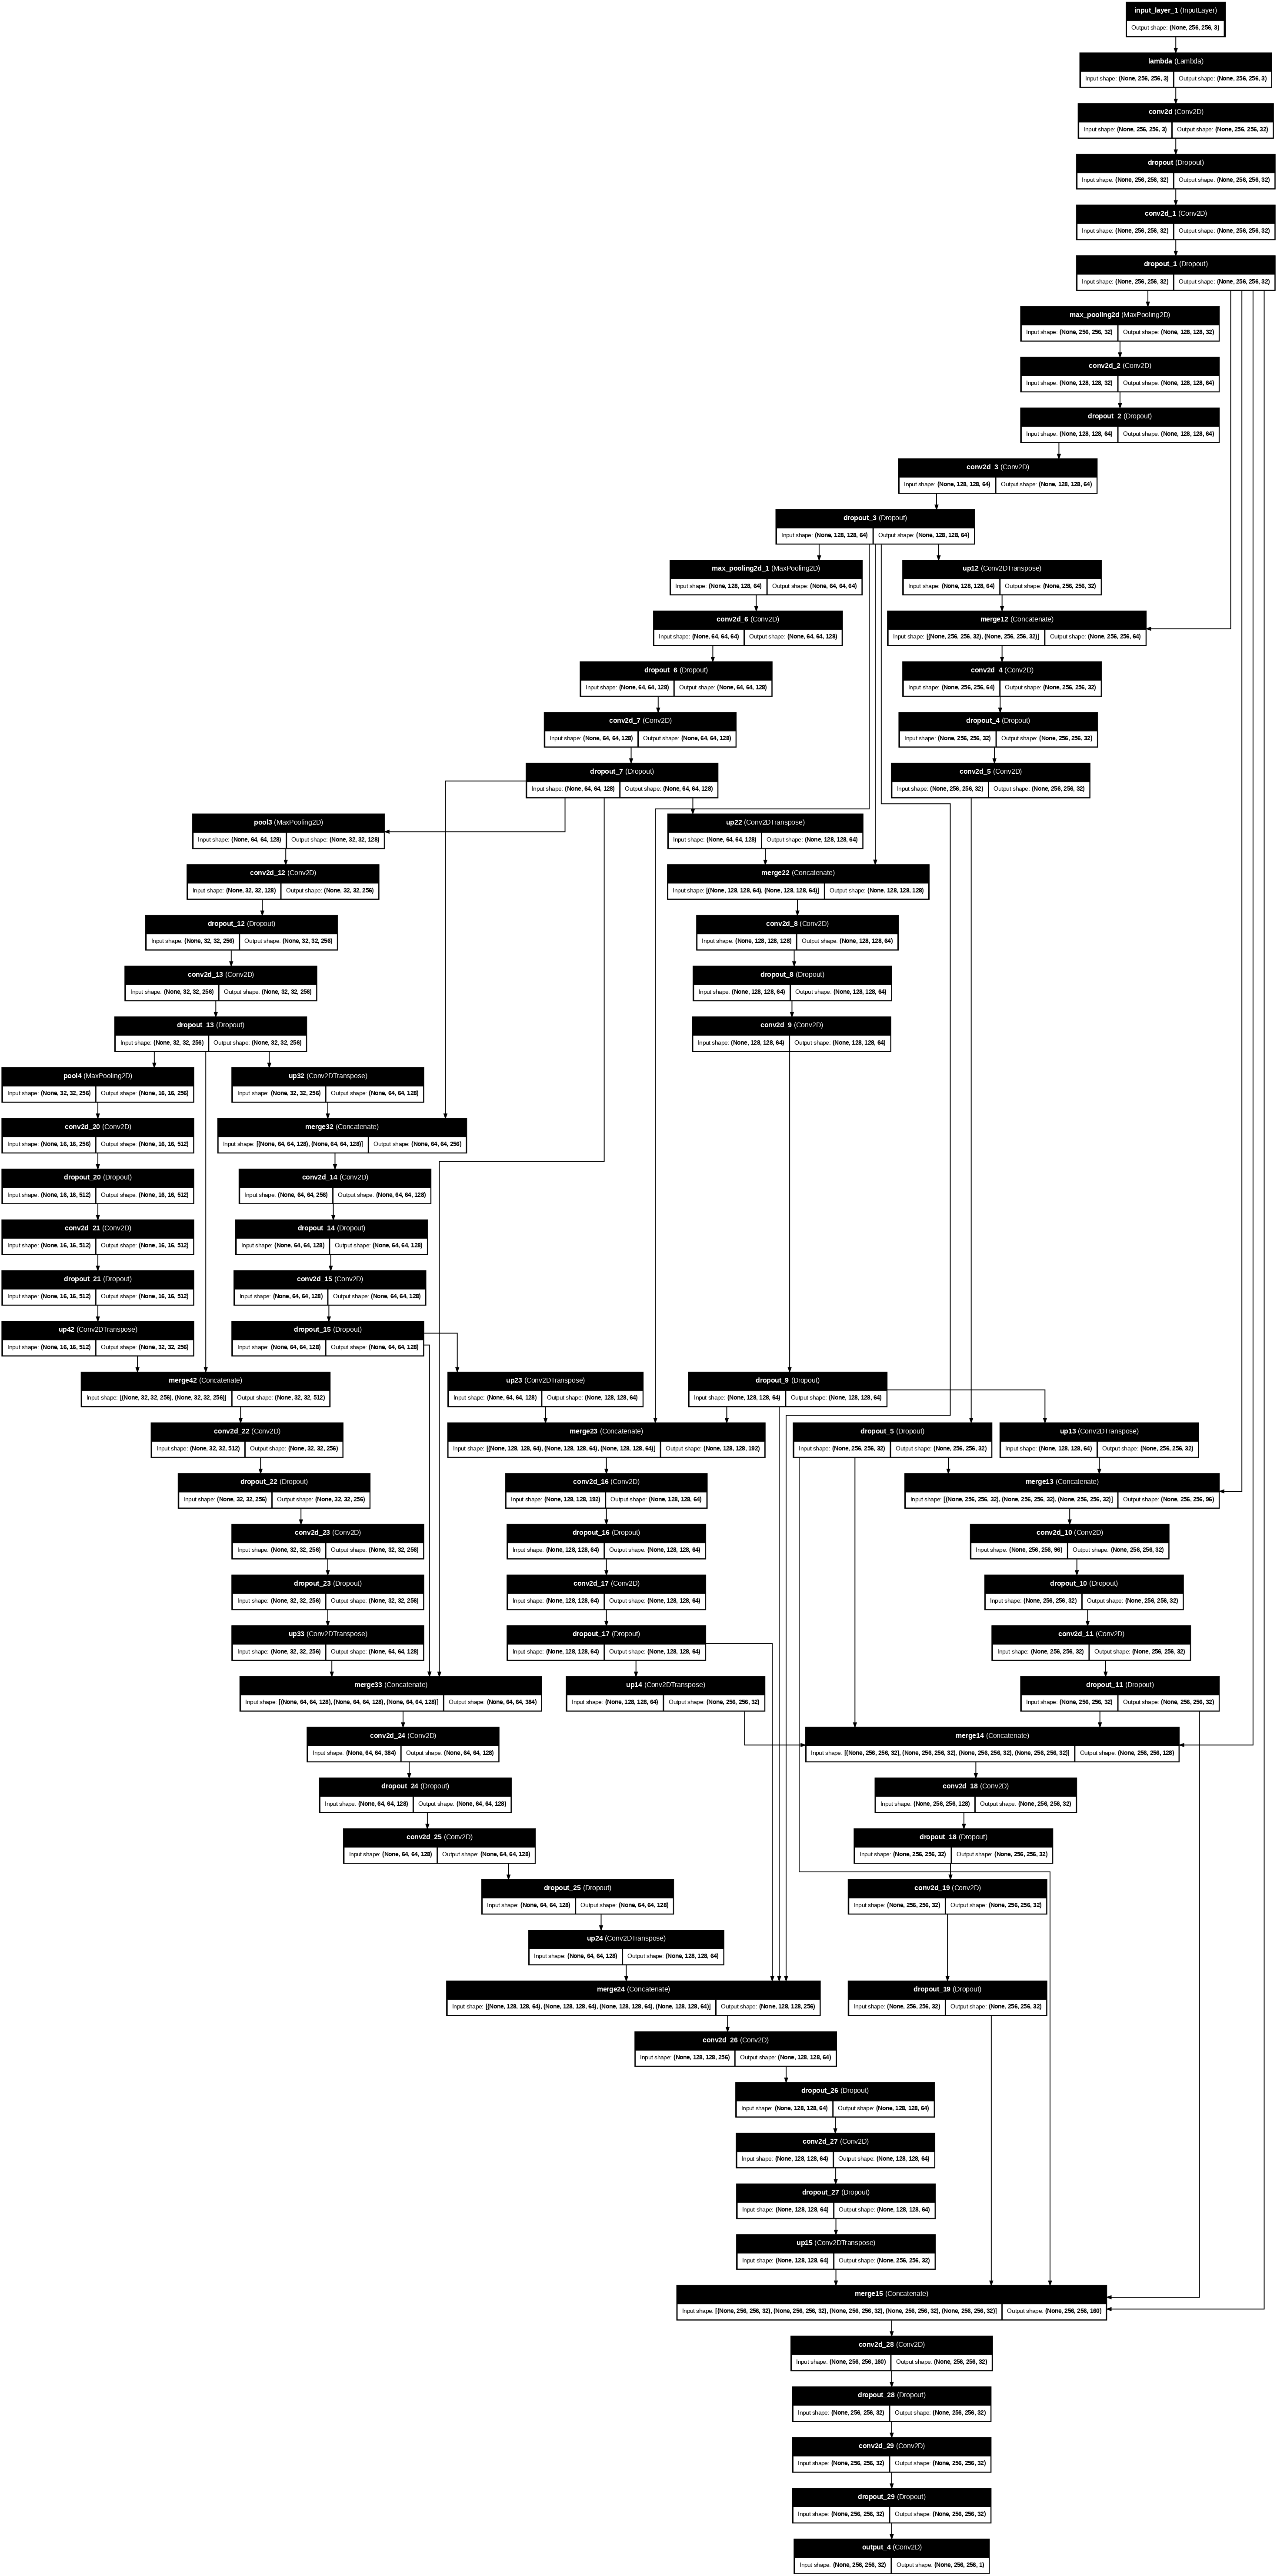

In [ ]:
# график структуры модели
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=70)

Callbacks

In [ ]:
checkpoint =  ModelCheckpoint("segmentation.keras", monitor='val_loss', save_best_only=True)

early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.01,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=10,
)
callbacks_list = [checkpoint,early]

In [ ]:
epochs = 50
history = model.fit(train_gen,
                    validation_data=valid_gen,
                    epochs=epochs,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks_list
                   )

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 109s 496ms/step - accuracy: 0.6918 - loss: 0.7770 - val_accuracy: 0.2517 - val_loss: 6.9206
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 78s 466ms/step - accuracy: 0.8163 - loss: 0.4337 - val_accuracy: 0.2512 - val_loss: 4.4916
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 445ms/step - accuracy: 0.8351 - loss: 0.3826 - val_accuracy: 0.2546 - val_loss: 9.2701
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 44s 484ms/step - accuracy: 0.8665 - loss: 0.3268 - val_accuracy: 0.3963 - val_loss: 4.0623
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 486ms/step - accuracy: 0.8804 - loss: 0.3065 - val_accuracy: 0.5407 - val_loss: 2.6756
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 446ms/step - accuracy: 0.9003 - loss: 0.2616 - val_accuracy: 0.3243 - val_loss: 4.1304
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 445ms/step - accuracy: 0.9059 - loss: 0.2490 - val_accuracy: 0.3922 - val_loss: 3.7335
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 452ms/step - accuracy: 0.9169 - loss: 0.2231 - val_accuracy: 0.45

Анализ результата

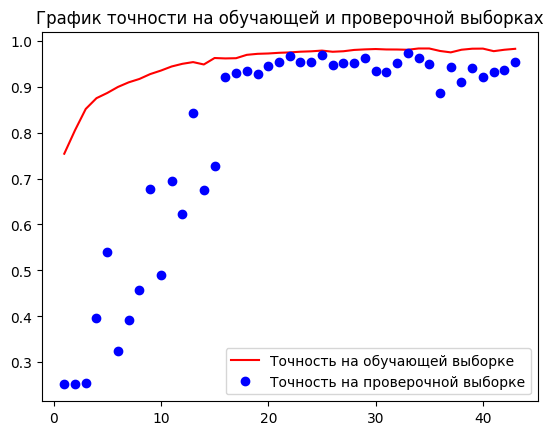

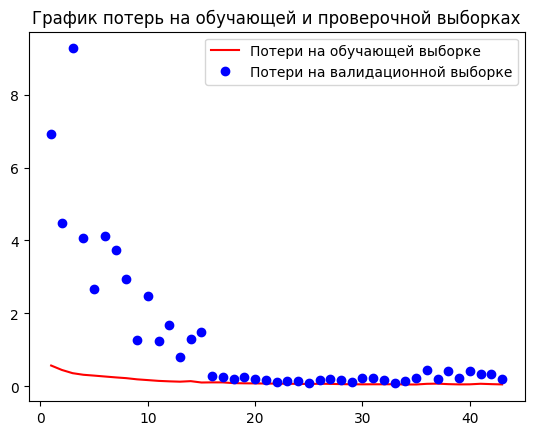

In [ ]:
acc = history.history['accuracy']                              # данные о точности на обучающей выборке
val_acc = history.history['val_accuracy']                      # данные о точности на проверочной выборке
loss = history.history['loss']                                             # данные об ошибке на обучающей выборке
val_loss = history.history['val_loss']                                     # данные об ошибке на проверочной выборке
epochs = range(1, len(acc) + 1)                                            # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')   #  строим график точность на проверочной выборке
plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.plot(epochs, val_loss, 'bo', label='Потери на валидационной выборке')  #  строим график потерь на проверочной выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()

Визуальная оценка

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[0])            # отображаем картинку
    plt.imshow(display_list[i],alpha=0.8)  # отображаем маску с прозрачностью 50%
    plt.axis('off')
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


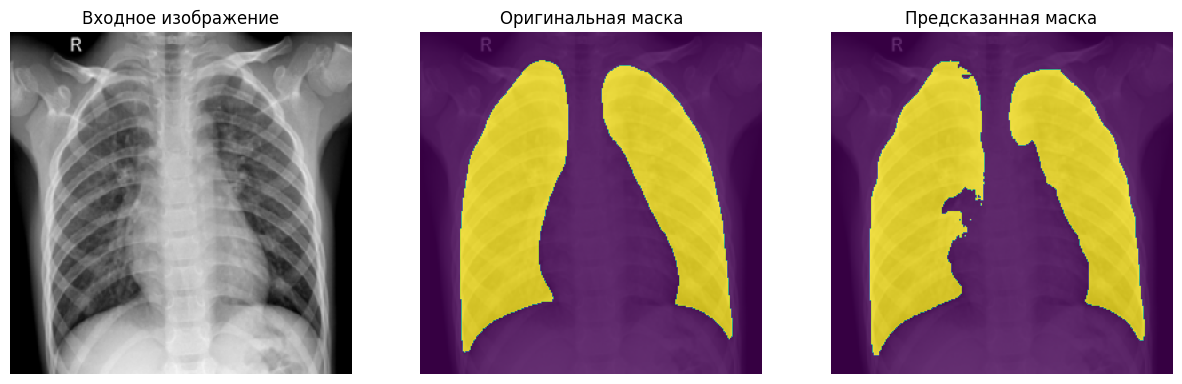

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


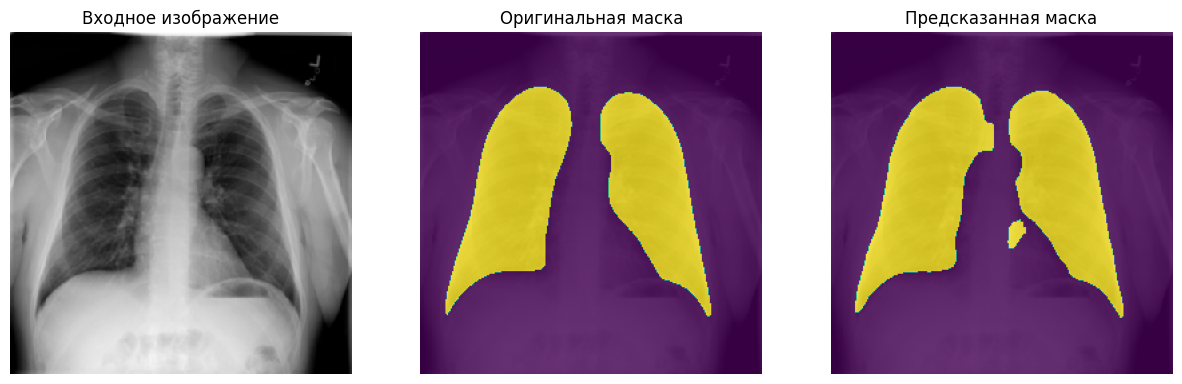

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


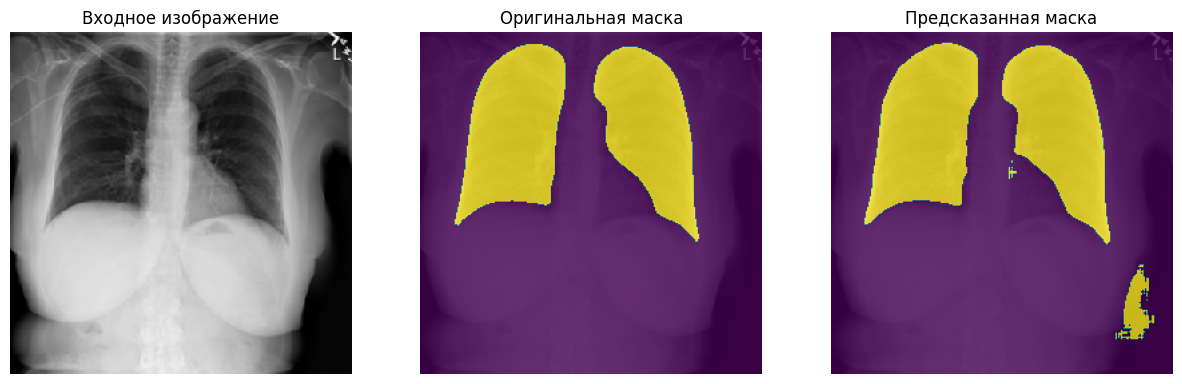

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


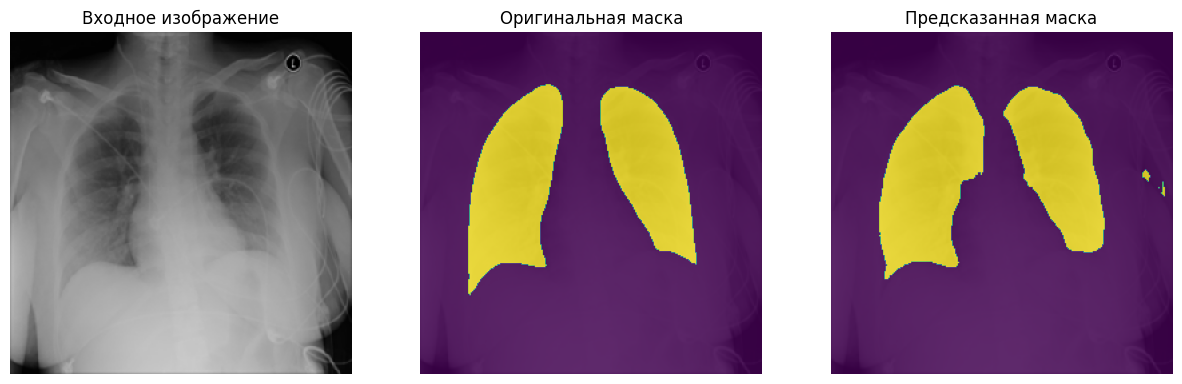

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


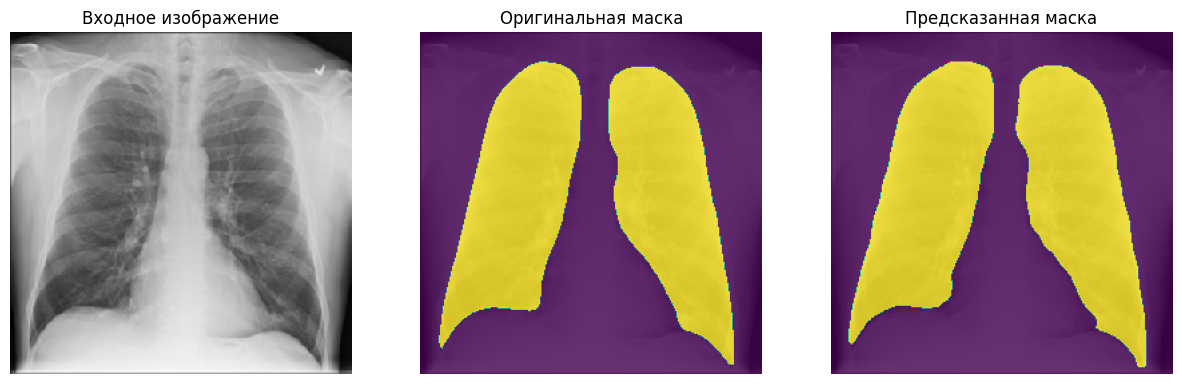

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


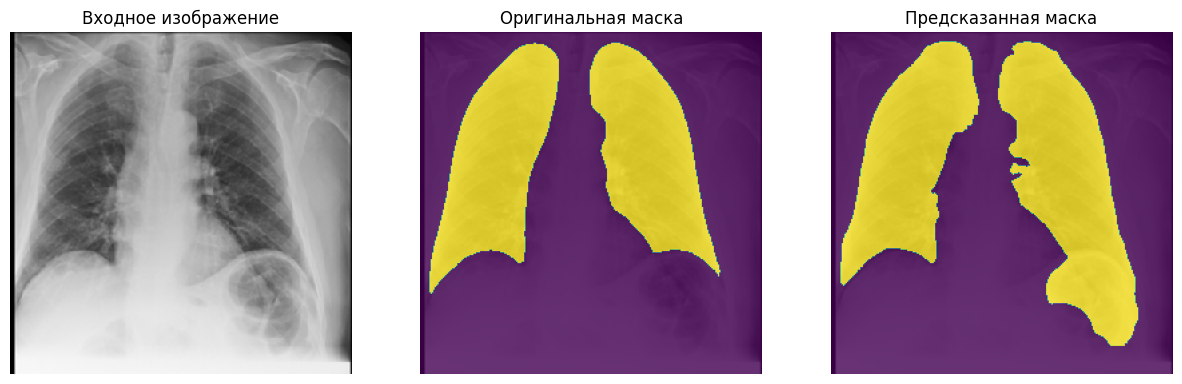

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


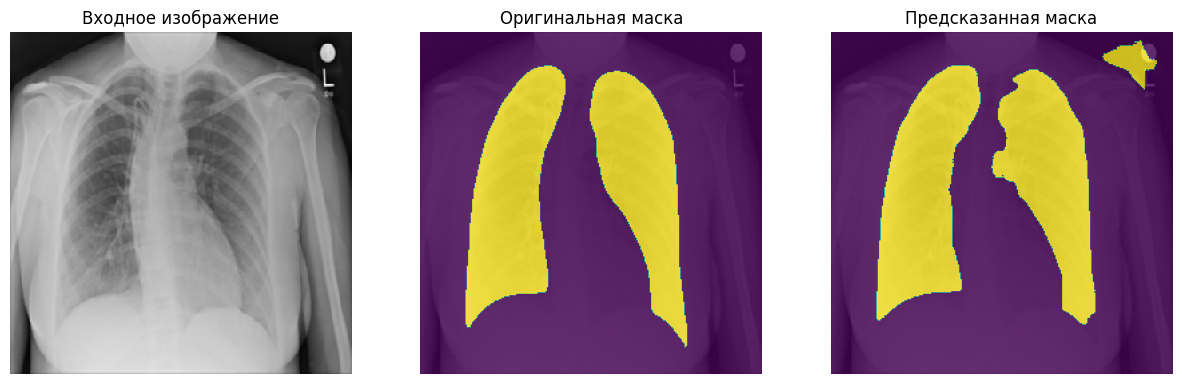

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


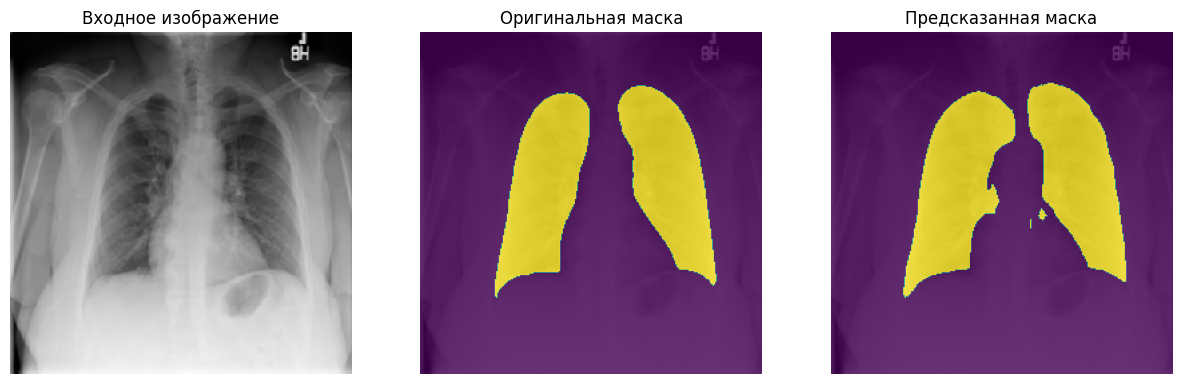

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


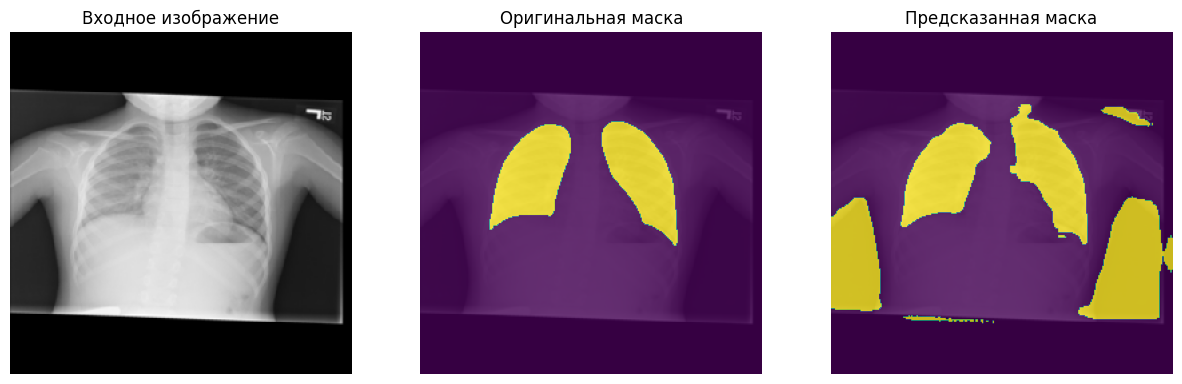

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


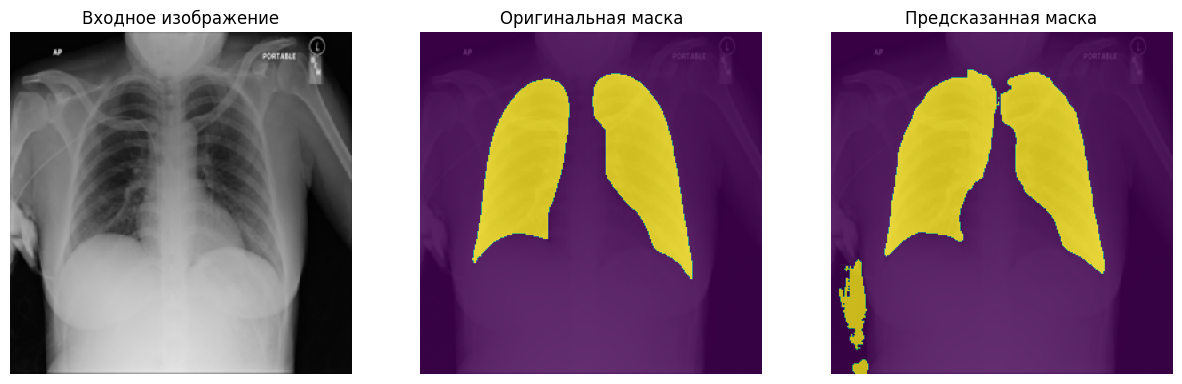

In [ ]:
for index in range(10):                  # выбираем 12 картинок и выводим их в цикле
    img = np.array(load_img(val_img[index], target_size=(256, 256), color_mode='rgb')) # загружаем картинку для предсказания
    mask = np.array(load_img(val_target[index], target_size=(256, 256), color_mode='grayscale')) # загружаем маску для сравнения с предсказанием

    # Запускаем модель в режиме предсказания
    test = model.predict(np.expand_dims(img, 0) / 255)

    # Выбираем наиболее веротный класс
    test = np.argmax(test, axis=-1)

    display([img.reshape(1, 256, 256, 3)[0], mask, test[0]])  # передаем в функцию display изображение, оригинальную маску и предсказанную